In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt

#  Pulses and Waveforms


A waveform is simply a time varying signal. When a pulse operation occurs, a digital to analog converter produces a signal by combinding the following data:

* a time varying complex function $ u(t) $ which describes the baseband waveform
* a *frequency* $f$, in Hertz,
* a *phase* $\theta$, in radians,
* a unitless *scale* $\alpha$.

The signal generated from this has the mathematical form
\begin{equation}
x(t) = \text{Re}[\alpha u(t)e^{i (\theta + 2 \pi f t)}],
\end{equation}
where $\text{Re}$ denotes the real part of a complex number. 

In accordance with the usual conventions, we will refer to the real part of $u(t)$ as the **in-phase** component, and the imaginary part as the **quadrature** component. A general complex number $z = x + iy$ will sometimes be referred to as an **IQ-value**, with $I = x$ and $Q = y$.


Quilt provides the programmer with pulse and capture-level control, both by allowing for custom baseband waveforms, as well as allowing for direct control over the run-time frequency, phase, and scale.


## Waveform Templates and References

There are two ways to specify a Quilt waveform:
- by using a pre-existing template, which has a shape dictated by certain parameters
- by referencing a custom waveform definition.

Consider the following Quilt code:
```
PULSE 0 "rf" flat(duration: 1e-6, iq: 0.5 + 0.5*i)
```
This denotes a pulse operation, on frame `0 "rf"`, with a total duration of one microsecond and with baseband waveform given by the `flat` template, (corresponding to $u(t) = 1/2 + i/2$ for the duration of the signal). The resulting signal produced depends also on the phase, frequency, and scaling factor associated with frame `0 "rf"`. These may be set explicitly, as in
```
SET-SCALE 0 "rf" 1.0
SET-FREQUENCY 0 "rf" 5e9
SET-PHASE 0 "rf" 0.0
```

On the other hand, a custom waveform may be defined and used. This is done using the `DEFWAVEFORM` form,
```
DEFWAVEFORM my_waveform:
    0.01, 0.01+0.01*i, ...
```
the body of which consists of a list of complex numbers. Such a custom waveform may be referenced directly by name, as in
```
PULSE 0 "rf" my_waveform.
```

The precise meaning of this depends on the *sample rate* of the associated frame: this indicates the number of samples per second consumed by the underlying digital-to-analog converter. For example, suppose that the definition of `0 "rf"` looked like this
```
DEFFRAME 0 "rf":
    SAMPLE-RATE: 1000000000.0
    INITIAL-FREQUENCY: 4807541957.13474
    DIRECTION: "tx"
```
and `my_waveform` has a definition consisting of complex numbers $z_1, \ldots, z_N$. Then, letting $r=10^9$ denote the sample rate, the resulting pulse has total duration $\left \lceil{\frac{N}{r}}\right \rceil$, corresponding to the baseband waveform $ u(t) = z_{\left \lfloor{tr}\right \rfloor}. $ Here $\left \lceil{x}\right \rceil $ and $\left \lfloor{x}\right \rfloor$ denote the ceiling and floor of $x$, respectively. 

As before, this baseband waveform is combined with the frame's scale, frequency, and phase during digital to analog conversion.


## A Catalog of Template Waveforms

Rigetti provides a number of templates by default. These include

- `flat`, corresponding to simple rectangular waveforms
- `gaussian`, for a Gaussian waveform
- `drag_gaussian`, for a Gaussian waveform modified by the Derivative Removal by Adiabatic Gate (DRAG) technique
- `hrm_gaussian`, for a DRAG Gaussian waveform with second-order corrections
- `erf_square`, for a flat waveform with smooth edges derived from the Gaussian error function
- `boxcar_kernel`, for a flat waveform which is normalized to integrate to 1

Each of these waveforms has a corresponding definition in `pyquil.quiltwaveforms`. In addition to providing documentation on the meaning of each of the waveform parameters, this module also contains routines for generating samples for each template.

Below we look at each individidually, discussing the meaning of various parameters and plotting the real part of the waveform envelope.

In [2]:
from pyquil.quilatom import TemplateWaveform

def plot_waveform(wf: TemplateWaveform, sample_rate: float):
    """ Plot a template waveform by sampling at the specified sample rate. """
    samples = wf.samples(sample_rate)
    times = np.arange(len(samples))/sample_rate

    print(wf)
    plt.plot(times, samples.real)
    plt.show()

### flat

A flat waveform is simple: it represents a constant signal for a certain duration. There are two required parameters:

* `duration`: the length of the waveform, in seconds
* `iq`: a complex number

flat(duration: 1e-06, iq: 1.0)


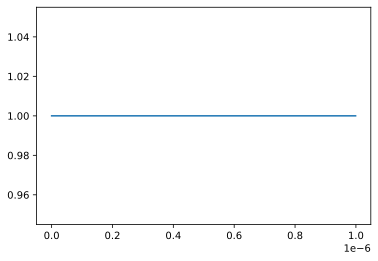

In [3]:
from pyquil.quiltwaveforms import FlatWaveform

plot_waveform(FlatWaveform(duration=1e-6, iq=1.0), sample_rate=1e9)

#### Scale, Phase, Detuning

In addition to the parameters specific to each template waveform, there are also a few generic parameters. One of these we have met: each template waveform has a required `duration` argument, indicating the length of the waveform in seconds.

The other arguments are *optional*, and are used to modulate the basic shape. These are

* scale $\alpha$, which has the effect of scaling the baseband $u(t) \mapsto \alpha u(t)$
* phase $\theta$, in radians, which has the effect of a phase shift on the baseband $u(t) \mapsto e^{i \theta} u(t)$
* detuning $f_d$, in Hertz, which has the effect of $u(t) \mapsto e^{2 \pi i f_d} u(t)$

These may be provided as arguments to any template waveform, e.g.
```
PULSE 0 "rf" flat(duration: 1e-8, iq: 1.0, scale: 0.3, phase: 1.570796, detuning: 1e8) 
```

Below we consider this by way of the PyQuil bindings.

flat(duration: 1e-06, iq: 1.0, detuning: 10000000.0)


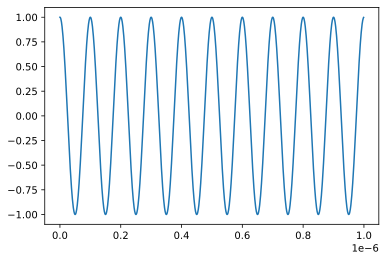

In [4]:
plot_waveform(FlatWaveform(duration=1e-6, iq=1.0, detuning=1e7), sample_rate=1e9)

### gaussian

Several of the template waveforms provided are derived from a standard (unnormalized) Gaussian. Here we have
\begin{equation}
u(t) = \text{exp}\Big(-\frac{(t-t_0)^2}{2 \sigma^2}\Big),
\end{equation}
where $t_0$ denotes the center of the Gaussian, and $\sigma$ is the usual standard deviation. 

By Quilt convention, this is parameterized by the Gaussian's [full width at half maximum](https://en.wikipedia.org/wiki/Full_width_at_half_maximum) (FWHM), which is defined to be

\begin{equation}
\text{FWHM} = 2 \sqrt{2 \ln(2)} \sigma.
\end{equation}

As with all Quilt waveforms, a Quilt `gaussian` has a finite duration, and thus corresponds to a truncation of a true Gaussian.

In short, the parameters are:

* `duration`: the duration of the waveform, in seconds. The Gaussian will be truncated to $[0, \text{duration}]$
* `t0`: the center of the Gaussian, in seconds
* `fwhm`: the full width half maximum of the Gaussian, in seconds

gaussian(duration: 1e-06, fwhm: 4e-07, t0: 5e-07)


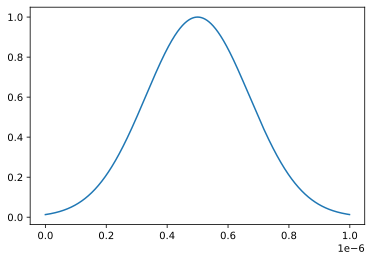

In [5]:
from pyquil.quiltwaveforms import GaussianWaveform

plot_waveform(GaussianWaveform(duration=1e-6, t0=5e-7, fwhm=4e-7), sample_rate=1e9)

### drag_gaussian

The `drag_gaussian` waveform extends the basic Gaussian with an additional correction factor (cf. https://arxiv.org/abs/1809.04919 and references therein). The shape is given by
\begin{equation}
u(t) = \Big(1 + i\frac{\alpha}{2 \pi \eta \sigma^2}\Big)\text{exp}\Big(-\frac{(t-t_0)^2}{2 \sigma^2}\Big),
\end{equation}
where $\eta$ is the anharmonicity constant, in Hz, and $\alpha$ is a dimensionless shape parameter.

As before, rather than providing $\sigma$ explicity, `drag_gaussian` takes a full-width half max parameter. 

In summary, the required arguments to `drag_gaussian` are:

* `duration`: the duration of the waveform, in seconds. The Gaussian will be truncated to $[0, \text{duration}]$
* `t0`: the center of the Gaussian, in seconds
* `fwhm`: the full width half maximum of the Gaussian, in seconds
* `anh`: the anharmonicity constant $\eta$, in Hertz
* `alpha`: dimensionless shape parameter $\alpha$.


drag_gaussian(duration: 1e-06, fwhm: 4e-07, t0: 5e-07, anh: 1.1, alpha: 1.0)


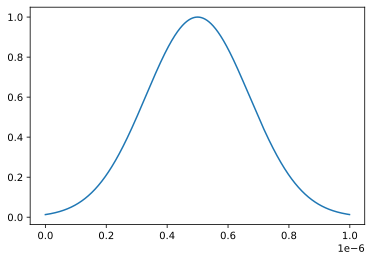

In [6]:
from pyquil.quiltwaveforms import DragGaussianWaveform

plot_waveform(
    DragGaussianWaveform(duration=1e-6, t0=5e-7, fwhm=4e-7, anh=1.1, alpha=1.0),
    sample_rate=1e9
)

Of course, we only plotted the *real part* of the waveform above. The imaginary part is relevant when the baseband waveform is converted to a passband waveform, as we can demonstrate below via the optional `detuning` argument.

drag_gaussian(duration: 1e-06, fwhm: 4e-07, t0: 5e-07, anh: 1.1, alpha: 1.0, detuning: 10000000.0)


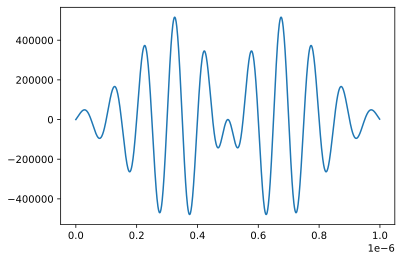

In [7]:
from pyquil.quiltwaveforms import DragGaussianWaveform

plot_waveform(
    DragGaussianWaveform(duration=1e-6, t0=5e-7, fwhm=4e-7, anh=1.1, alpha=1.0, detuning=1e7),
    sample_rate=1e9
)

### hrm_gaussian

The `hrm_gaussian` waveform is a variant of `drag_gaussian` which incorporates a higher order term. The shape is given by
\begin{equation}
u(t) = \Big(1 - H_2 \frac{(t-t_0)^2}{2 \sigma^2} + i\frac{\alpha (t-t_0)}{2 \pi \eta \sigma^2} \big(1 - H_2 \big(\frac{(t-t_0)^2}{2\sigma^2} - 1\big)\Big)\text{exp}\Big(-\frac{(t-t_0)^2}{2 \sigma^2}\Big),
\end{equation}
where $\alpha$ is a dimensionless DRAG parameter, $\eta$ is the anharmonicity constant, and $H_2$ is a second order correction coefficient (cf. [1]). Note that when $H_2$ equals 0 this reduces to an ordinary `drag_gaussian`.

The required arguments to `hrm_gaussian` are:

* `duration`: the duration of the waveform, in seconds. The Gaussian will be truncated to $[0, \text{duration}]$
* `t0`: the center of the Gaussian, in seconds
* `fwhm`: the full width half maximum of the Gaussian, in seconds
* `anh`: the anharmonicity constant $\eta$, in Hertz
* `alpha`: dimensionless shape parameter $\alpha$
* `second_order_hrm_coeff`: the constant $H_2$.

[1] Warren, W. S. (1984). Effects of arbitrary laser or NMR pulse shapes on population inversion and coherence. The Journal of Chemical Physics, 81(12), 5437–5448. doi:10.1063/1.447644 

hrm_gaussian(duration: 1e-06, fwhm: 4e-07, t0: 5e-07, anh: 1.1, alpha: 1.0, second_order_hrm_coeff: 0.5)


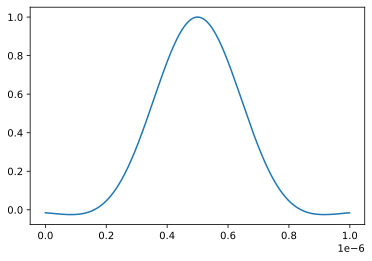

In [8]:
from pyquil.quiltwaveforms import HrmGaussianWaveform

plot_waveform(
    HrmGaussianWaveform(duration=1e-6, t0=5e-7, fwhm=4e-7, anh=1.1, alpha=1.0, second_order_hrm_coeff=0.5),
    sample_rate=1e9
)

### erf_square

The `erf_square` waveform is a variant of `flat_waveform` with the boundary discontinuities smoothed via the [error function](https://en.wikipedia.org/wiki/Error_function) (erf), and additional zero-padding.

The required arguments are:

* `duration`: the duration of the nonzero part of the waveform, in seconds
* `risetime`: width of each of the rise and fall sections of the pulse, in seconds
* `pad_left`: amount of zero-padding to add to the left of the pulse, in seconds
* `pad_right`: amount of zero-padding to add to the right of the pulse, in seconds

**NOTE**: The total duration of the waveform is `duration + pad_left + pad_right`; the total duration of the *support* (nonzero entries) is `duration`.


erf_square(duration: 1e-06, risetime: 1e-07, pad_left: 1e-07, pad_right: 1e-07)


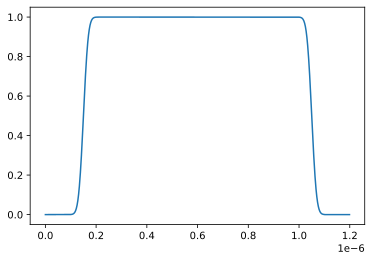

In [9]:
from pyquil.quiltwaveforms import ErfSquareWaveform

plot_waveform(
    ErfSquareWaveform(duration=1e-6, risetime=1e-7, pad_left=1e-7, pad_right=1e-7),
    sample_rate=1e9
)

## Capture and Kernels

In Quilt, waveforms are used in two places:

* in a `PULSE` operation, to specify what signal is generated
* in a `CAPTURE` operation, to specify how to resolve a signal into a number

The `CAPTURE` operation involves reading in a signal on a suitable signal line, and integrating it with respect to a *kernel*. 

Mathematically, there is a real-valued signal $ s(t), $ corresponding to a reading on the signal line. This is combined with a complex-valued "baseband" kernel $k(t)$ to get a resulting **IQ value** $z$ by
\begin{equation}
z = \int_{t_\text{min}}^{t_\text{max}} k(t) s(t) e^{-2 \pi i f t} \, dt, 
\end{equation}
where $f$ denotes the frequency of the associated capture frame.


In Quilt, this integrating kernel is specified by a waveform, with the usual convention that is is scaled to satisfy $\int k(t) \, dt = 1.$ The most common example is the `boxcar_kernel`, which corresponds to a flat pulse scaled to satisfy this condition.



### boxcar_kernel

Because of the normalization condition, the `boxcar_kernel` requires only a `duration` argument for its construction.

boxcar_kernel(duration: 1e-06)


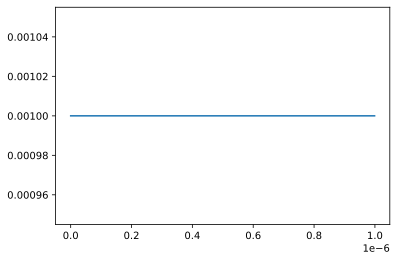

In [10]:
from pyquil.quiltwaveforms import BoxcarAveragerKernel

plot_waveform(
    BoxcarAveragerKernel(duration=1e-6),
    sample_rate=1e9
)

The samples should sum to (roughly) one.

In [11]:
assert np.isclose(
    np.sum(BoxcarAveragerKernel(duration=1e-6).samples(1e9)),
    1.0
)

**Note**: The reference implementations of these waveforms makes use of Python's double precision floating point arithmetic. The *actual* implementation involves a certain amount of hardware dependence. For example, Rigetti's waveform generation hardware currently makes use of 16 bit fixed point arithmetic.

## Compile Time versus Run Time

When thinking about parameters in Quilt, there are two times to consider:
* the time of compilation, when a Quilt program is translated to a binary format executable on Rigetti hardware
* the time at which the program is run.

**All template parameters must be resolved at compile time.** The Quilt compiler depends on being able to determine the size and contents of waveforms in advane. In other words, the following is not allowed:
```
DECLARE theta REAL
PULSE 0 "rf" flat(duration: 1e-8, iq: 1.0, phase: theta)
```
However, the following program is valid, and does something equivalent
```
DECLARE theta REAL
SHIFT-PHASE 0 "rf" theta
PULSE 0 "rf" flat(duration: 1e-8, iq: 1.0)
SHIFT-PHASE 0 "rf" -theta
```
(Why the second `SHIFT-PHASE`? To leave the frame `0 "rf"` as it was before we started!)


Explicit control over the *run-time* phase, frequency, or scale requires the use of one of the following instructions.

* `SET-SCALE`
* `SET-PHASE`
* `SHIFT-PHASE`
* `SET-FREQUENCY`
* `SHIFT-FREQUENCY`

all of which support run-time parameter arguments.